# **Optimizing Explanations: Nuances Matter When Evaluation Metrics Become Loss Functions**

*Authors: Jonas B. Raedler, Hiwot Belay Tadesse, Weiwei Pan, Finale Doshi-Velez*

---
This is the notebook that accompanies our paper, published at the *Methods and Opportunities at Small Scale (MOSS)* workshop, held at ICML 2025 (Vancouver, Canada).

**Please Read:**

In the interest of time, this notebook does not run our experiments on the entire considered data. Instead, we choose to only run them for dimensions 2 and 4, and only for the perturbation region $u=5$. We use all the functions that were considered in the paper. If interested, people can adjust variables to generate results for other data.

Additional Note: in the paper, we used the MOSEK solver, which requires a license (they provide free academic licenses: https://www.mosek.com/). We provide an alternative solver here (`solver="SCS"`) that is freely available through the `cvxpy` library, which leads to very similar results (we note, though, that some minor differences may occur).

**1. Imports**
---

In [ ]:
import autograd.numpy as np
from autograd import elementwise_grad
import cvxpy as cp
import json
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

**2. Function Definitions**
---

In [ ]:
# These are the functions used in the paper

def fn_squared(X):
  '''fn_squared'''
  return np.sum(np.power(X, 2), axis=1)

def fn_cubed(X):
  '''fn_cubed'''
  return np.sum(0.35 * np.power(X, 3), axis=1)

def fn_sin_ex(X):
  '''fn_sin_ex'''
  return np.sum(np.sin(2*X) + 0.1*np.exp(X) - 0.5*np.power(X, 2), axis=1)

def fn_sin(X):
  '''fn_sin'''
  return np.sum(np.sin(X), axis=1)

def fn_sin_cubed(X):
  '''fn_sin_cubed'''
  return np.sum(np.sin(0.35 * np.power(X, 3)), axis=1)

**3. Helper Functions**
---

In [ ]:
def compute_gradient(fn, X):
     '''
     Computes the gradient of the given function with respect to the input dataset.

     Parameters:
     -----------
     fn : function
          The function for which the gradient is being computed. The function should take
          an (N, D) shaped input and return an (N, ) shaped output.
     X : numpy.ndarray
          The input dataset of shape (N, D), where N is the number of samples and D is the number of features.

     Returns:
     --------
     gradient_set : numpy.ndarray
          A (N, D) array representing the gradient of the function with respect to each element in the input X.
          Each entry corresponds to the partial derivative of the function with respect to that input feature.
     '''
     f_grad = elementwise_grad(fn)
     gradient_set = f_grad(X)
     return gradient_set



def make_grid(lower, upper, num_points, num_dimensions):
    '''
    Creates a grid of evenly spaced points in multi-dimensional space.

    Parameters:
    -----------
    lower : float
        The lower bound of the grid for each dimension.
    upper : float
        The upper bound of the grid for each dimension.
    num_points : int
        The total number of points to generate in the grid.
    num_dimensions : int
        The number of dimensions for the grid.

    Returns:
    --------
    grid : numpy.ndarray
        A (num_points, num_dimensions) array where each row represents a point
        in the grid, and each column corresponds to one dimension.
    '''
    for grid_size in range(2, num_points+1):
        total_points = grid_size ** num_dimensions
        if total_points >= num_points:
            break

    x = np.linspace(lower, upper, grid_size)
    arrs = np.meshgrid(*([x] * num_dimensions))
    grid = np.concatenate([x.flatten()[..., None] for x in arrs], axis=-1)

    # If the grid has more points than desired, truncate it
    # if grid.shape[0] > num_points:
    #     grid = grid[:num_points]

    return grid


# For each point in X, compute a uniform probability distribution over all points within the specified perturbation_region radius
def get_probability_distributions(X, perturbation_region):

    N = X.shape[0]

    # get the uniform probability distributions iteratively
    probability_distributions = []

    # for a fixed n, see how many elements are within the perturbation region
    # all these elements will have a uniform probability
    for n in range(N):
        p_n = []
        for n_prime in range(N):
            if np.linalg.norm(X[n] - X[n_prime]) <= perturbation_region:
                p_n.append(1)
            else:
                p_n.append(0)

        p_n = np.asarray(p_n)
        p_n = p_n / np.sum(p_n)
        probability_distributions.append(p_n)

    return probability_distributions


def save_to_json(fn, dim, r, data, path=None):
    """
        Input
        - fn: a function object whose __doc__ string (i.e. the function name) is used as the key in the JSON file
        - dim: the dimension of the data. Also a key in the JSON file
        - r: the perturbation region used to generate the explanations. Also a key in the JSON file
        - data: the data that's saved in the JSON file

        Output: None

        Functionality: this function reads in the existing JSON file and saves the data in json[fn_name][dim][r] = data.
    """

    json_file_path = path


    if not os.path.exists(json_file_path):
         with open(json_file_path, "w") as f:
              json.dump({}, f, indent=4)

    with open(json_file_path, 'r') as f:
        json_dict = json.load(f)

    fn_name = fn.__doc__
    if fn_name in json_dict:
        # Function name already exists in dict.
        json_dict[fn_name] = data
    else:
        # make it completely new
        json_dict[fn_name] = data

    with open(json_file_path, 'w') as f:
        json.dump(json_dict, f, indent=4)

    print(f"Saved: fn={fn_name}, Dim={dim}, r={r}.")

**4. Solvers**
---

In [ ]:
def init_solver(r_optimization_metric, fn, X, perturbation_region, desired_f_loss=None):
    """
    Initializes a convex optimization problem to learn explanation vectors that balance
    faithfulness to a model's gradients with robustness to small input perturbations.

    Parameters
    ----------
    metric : str
        The robustness metric to use. Options include:
        - "max-sens": Maximum sensitivity — penalizes large changes in explanations across nearby inputs.
        - "loc-stab": Local stability — penalizes explanation variability scaled by input distance.
        - "avg-sens": Average sensitivity — penalizes expected explanation differences under a local perturbation distribution.

    fn : callable
        A scalar-valued function (e.g., a prediction function) over which to compute gradients.

    X : np.ndarray of shape (N, D)
        The input dataset with N samples and D features.

    perturbation_region : float
        A threshold defining the neighborhood size for considering input perturbations.

    Returns
    -------
    problem : cvxpy.Problem
        The convex optimization problem combining faithfulness and robustness losses.

    r_lambda : cvxpy.Parameter
        A tunable scalar parameter weighting the robustness loss in the objective.

    f_lambda : cvxpy.Parameter
        A tunable scalar parameter weighting the faithfulness loss in the objective.

    W_E : cvxpy.Variable of shape (N, D)
        The explanation vectors to be learned by solving the optimization problem.

    W_G : cvxpy.Parameter of shape (N, D)
        The fixed ground-truth gradient vectors computed from `fn` over `X`.

    Notes
    -----
    The objective function has the form:
        total_loss = f_lambda * faithfulness_loss + r_lambda * robustness_loss

    - Faithfulness loss encourages `W_E` to match the gradients `W_G`.
    - Robustness loss penalizes differences in `W_E` across local perturbations,
      according to the selected metric.
    """

    N, D = X.shape
    W_E = cp.Variable((N, D), name="W_E")
    W_G = cp.Parameter((N, D), name="W_G") # ground truth

    W_G.value = compute_gradient(fn, X)
    constraints = []

    # Robustness Loss is different across different metrics!
    if r_optimization_metric in ["max-sens", "loc-stab"]:
        differences = cp.Variable(N, name="diffs")
        robustness_loss = cp.sum(differences)

        # Define Constraints
        for i in range(N):
            for j in range(N):
                if i != j and np.linalg.norm(X[i] - X[j]) <= perturbation_region:

                    if r_optimization_metric == "max-sens":
                        constraints.append(differences[i] >= cp.norm(W_E[i] - W_E[j], p=2))
                    elif r_optimization_metric == "loc-stab":
                        constraints.append(differences[i] >= cp.norm(W_E[i] - W_E[j], p=2) / (cp.norm(X[i] - X[j]) + 1e-16))

    elif r_optimization_metric == "avg-sens":
        p = get_probability_distributions(X, perturbation_region)
        weighted_distances = []
        for n in range(N):
            for n_prime in range(N):
                if n != n_prime and p[n][n_prime] != 0:
                    weighted_distances.append(cp.norm(W_E[n] - W_E[n_prime], 2) * p[n][n_prime])

        robustness_loss = cp.sum(weighted_distances)


    if desired_f_loss is None:
        ### Execute this if solving for a specific lambda-tradeoff.

        # Faithfulness Loss is the same across all metrics
        faithfulness_loss = cp.Variable(name="f_loss", nonneg=True)
        constraints.append(faithfulness_loss >= cp.sum_squares(W_G - W_E))

        # Overall Problem
        # (1 - lambda ) * f_loss + lambda * r_loss
        # = f_lambda * f_loss + r_lambda * r_loss
        r_lambda = cp.Parameter(name="r_lambda", nonneg=True)
        f_lambda = cp.Parameter(name="f_lambda", nonneg=True)

        total_loss = f_lambda * faithfulness_loss + r_lambda * robustness_loss

        objective = cp.Minimize(total_loss)
        problem = cp.Problem(objective, constraints)

        return [problem, r_lambda, f_lambda, W_E, W_G]

    else:
        ### Execute this if solving for a specific faithfulness loss
        faithfulness_loss = cp.Parameter(name="f_loss", nonneg=True)
        faithfulness_loss.value = desired_f_loss

        constraints.append(faithfulness_loss >= cp.sum_squares(W_G - W_E))
        #constraints.append(cp.sum(cp.square(cp.norm(W_G - W_E, p=2, axis=1))) >= 0)

        total_loss = robustness_loss

        objective = cp.Minimize(total_loss)
        problem = cp.Problem(objective, constraints)

        return [problem, W_E, W_G]


# If the problem is solved given a specific faithfulness loss, use this function
def solve_problem_without_lambda(solver_params, solver="SCS", eps=1e-5, warm_start=True, verbose=False):
    problem, W_E, W_G = solver_params

    try:
        problem.solve(solver=solver, eps=eps, warm_start=warm_start, verbose=verbose)
        print(f"Problem Status: {problem.status}")
        W_E_opt = W_E.value
        return W_E_opt

    except Exception as e:
        print(f"Couldn't solve for desired f_loss.")
        print(e)
        return None, None


# If the problem is solved given a specified trade-off between faithfulness and robustness, define this
# tradeoff using lambda and use this function
def solve_problem_with_lambda(solver_params, lambda_val, solver="SCS", eps=1e-5, warm_start=True, verbose=False):

    # solver_params = [problem, r_lambda, f_lambda, W_E, W_G]
    problem, r_lambda, f_lambda, W_E, W_G = solver_params

    # Initialize the desired lambda value
    r_lambda.value = lambda_val
    f_lambda.value = 1 - lambda_val

    try:
        problem.solve(solver=solver, eps=eps, warm_start=warm_start, verbose=verbose)
        print(f"Problem Status: {problem.status}")
        W_E_opt = W_E.value

        return W_E_opt, [problem, r_lambda, f_lambda, W_E, W_G]

    except Exception as e:
        print(f"Couldn't solve for lambda {lambda_val}")
        print(e)
        return None, None

# given solver parameters, solves the problem using lambda and reports the evaluation metrics for resulting explanation
def get_optimal_explanation_and_losses(solver_params, lambda_val, r_eval_metric, X, perturbation_region):

    W_E_opt, solver_params = solve_problem_with_lambda(solver_params, lambda_val)
    if W_E_opt is None:
        print("Error in solving... Exiting.")
        return None, None, None, None

    faithfulness_loss = compute_faithfulness_loss(solver_params[-1].value, W_E_opt)   # solver_params[-1] = W_G
    robustness_loss = compute_robustness_loss(r_eval_metric, W_E_opt, X, perturbation_region)
    return W_E_opt, faithfulness_loss, robustness_loss, solver_params


# solves the problem for a fixed faithfulness loss
def find_20th_percentile_f_loss(r_optimization_metric, fn, X, perturbation_region):
    solver_params = init_solver(r_optimization_metric, fn, X, perturbation_region)

    # lambda = 0 --> best f_loss (=0)
    # lambda = 1 --> best r_loss (worst f_loss)

    lambda_val = 1 # this will give the maximum f_loss (which we can then scale down as desired)
    _, f_loss, _, solver_params = get_optimal_explanation_and_losses(solver_params, lambda_val, r_optimization_metric,
                                                                     X, perturbation_region)

    desired_f_loss = f_loss * 0.2
    return desired_f_loss


**5. Metrics**
---

In [ ]:
def compute_faithfulness_loss(W_G, W_E):
    """
	compute_faithfulness_loss : computes the loss for the faithfulness objective
	input : W_G(N, D), the gradient of the function to explain
		  : W_E(N,D), an explantion of the function using Smoothgrad and Lime
	output(): summation: A sum of the difference between the W_G and W_E
	"""
    return np.sum(np.square(np.linalg.norm(W_G - W_E, axis=1)))


# computes the robustness loss for the different considered metrics
def compute_robustness_loss(metric, W_E, X, r):
    sum_of_differences = 0
    N = len(X)

    # If metric is avg-sens:
    if metric == "avg-sens":
        p = get_probability_distributions(X, r)

        weighted_distances = 0
        for n in range(N):
            for n_prime in range(N):
                weighted_distances += np.linalg.norm(W_E[n] - W_E[n_prime]) * p[n][n_prime]

        return weighted_distances

    # If metric is max-sens or loc-stab:
    for i in range(N):
        max_difference_for_i = 0

        for j in range(N):
            # check if X[j] is within the defined perturbation region of X[i]
            if np.linalg.norm(X[i] - X[j]) <= r:

                if metric == "max-sens":
                    difference = np.linalg.norm(W_E[i] - W_E[j])
                elif metric == "loc-stab":
                    difference = np.linalg.norm(W_E[i] - W_E[j]) / (np.linalg.norm(X[i] - X[j]) + 1e-16)

                # update max_difference
                if difference > max_difference_for_i:
                    max_difference_for_i = difference
        sum_of_differences += max_difference_for_i

    return sum_of_differences

**6. Get Explanations**
---

In [ ]:
# gets the explanation given a function, input dimensionality, and perturbation region
def get_explanations(fn, dim, perturbation_region):

  function_map = {
      "cubed": fn_cubed,
      "squared": fn_squared,
      "sin_ex": fn_sin_ex,
      "sin": fn_sin,
      "sin_cubed": fn_sin_cubed
  }

  fn = function_map.get(fn)
  loss_metrics = ["max-sens", "loc-stab", "avg-sens"]

  N = 80
  X = make_grid(-5, 5, N, dim)

  print(f"Number of Points: {len(X)}\n")
  print("DISTANCE BETWEEN FIRST TWO INPUTS", np.linalg.norm(X[0] - X[1]))
  print(f"Function: {fn.__name__}\nu: {perturbation_region}\ndim: {dim}\nN: {len(X)}\nmetrics: {loss_metrics}")

  # initialize the json path used for saving results
  json_path = f"opt_expls_dim{dim}_u{perturbation_region}.json"

  eval_under_r_loss = {
      "max-sens": {},
      "loc-stab": {},
      "avg-sens": {}
  }

  # Get explanations optimized under each metric
  for r_eval_metric in loss_metrics:
      print(f"Evaluating explanations for (Function: {fn.__name__}, dim: {dim}, r: {perturbation_region}) under robustness loss: {r_eval_metric}.\n")

      results_dict = {
          "max-sens": {},
          "loc-stab": {},
          "avg-sens": {}
      }

      for r_optimization_metric in eval_under_r_loss.keys():
          print(f"Getting optimal explanations for {r_optimization_metric}...")

          desired_f_loss = find_20th_percentile_f_loss(r_optimization_metric, fn, X, perturbation_region)
          solver_params = init_solver(r_optimization_metric, fn, X, perturbation_region, desired_f_loss)
          W_E_opt = solve_problem_without_lambda(solver_params)

          f_loss = compute_faithfulness_loss(solver_params[-1].value, W_E_opt)   # solver_params[-1] = W_G
          r_loss = compute_robustness_loss(r_eval_metric, W_E_opt, X, perturbation_region)

          results_dict[r_optimization_metric] = {}
          results_dict[r_optimization_metric]["f_loss"] = f_loss
          results_dict[r_optimization_metric]["r_loss"] = r_loss
          results_dict[r_optimization_metric]["w_opt"] = W_E_opt.tolist()

      eval_under_r_loss[r_eval_metric] = results_dict
      save_to_json(fn, dim, perturbation_region, eval_under_r_loss, json_path)
      print("-------------\n")

**7. Run Experiment**
---

In [ ]:
functions = ["cubed", "squared", "sin_ex", "sin", "sin_cubed"]

error_msgs = []
for fn in functions:
    for dim in [2, 4]:
        for r in [5]:

            try:
                get_explanations(fn, dim, r)
            except Exception as e:
                print("ERROR", e)
                error_string = f"Function {fn}, dim {dim}, r {r} didn't work"
                error_msgs.append(error_string)

Number of Points: 81

DISTANCE BETWEEN FIRST TWO INPUTS 1.25
Function: fn_cubed
u: 5
dim: 2
N: 81
metrics: ['max-sens', 'loc-stab', 'avg-sens']
Evaluating explanations for (Function: fn_cubed, dim: 2, r: 5) under robustness loss: max-sens.

Getting optimal explanations for max-sens...
Problem Status: optimal


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Problem Status: optimal_inaccurate
Getting optimal explanations for loc-stab...
Problem Status: optimal
Problem Status: optimal_inaccurate
Getting optimal explanations for avg-sens...


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Problem Status: optimal
Problem Status: optimal_inaccurate
Saved: fn=fn_cubed, Dim=2, r=5.
-------------

Evaluating explanations for (Function: fn_cubed, dim: 2, r: 5) under robustness loss: loc-stab.

Getting optimal explanations for max-sens...
Problem Status: optimal
Problem Status: optimal_inaccurate
Getting optimal explanations for loc-stab...
Problem Status: optimal
Problem Status: optimal_inaccurate
Getting optimal explanations for avg-sens...
Problem Status: optimal
Problem Status: optimal_inaccurate
Saved: fn=fn_cubed, Dim=2, r=5.
-------------

Evaluating explanations for (Function: fn_cubed, dim: 2, r: 5) under robustness loss: avg-sens.

Getting optimal explanations for max-sens...
Problem Status: optimal
Problem Status: optimal_inaccurate
Getting optimal explanations for loc-stab...
Problem Status: optimal
Problem Status: optimal_inaccurate
Getting optimal explanations for avg-sens...
Problem Status: optimal
Problem Status: optimal_inaccurate
Saved: fn=fn_cubed, Dim=2, r=

**8. Create Agreement Rates Tables**
---

In [ ]:
# load the explanations from the created json files
def process_file_name(file_name):
    file_name = file_name.split(".json")[0]
    file_name, r = file_name.split("_u")
    dim = file_name.split("dim")[1]
    return dim, r

all_files = ["opt_expls_dim2_u5.json", "opt_expls_dim4_u5.json"]
jsons_dict = {}
for file in all_files:
    dim, r = process_file_name(file)

    if dim not in jsons_dict:
        jsons_dict[dim] = {}

    with open( file, 'r') as f:
        jsons_dict[dim][r] = json.load(f)

In [ ]:
def get_agreement_rate(expl_a, expl_b):
    return np.sum(np.argmax(expl_a, axis=1) == np.argmax(expl_b, axis=1)) / len(expl_a)


dimensions = list(jsons_dict.keys())

all_functions = ["fn_squared", "fn_cubed", "fn_sin_ex", "fn_sin", "fn_sin_cubed"]
metrics = ["max-sens", "loc-stab", "avg-sens"]
comparisons = ["Avg v Max", "Avg v Loc", "Max v Loc"]


# Get Agreement Rates
agreement_rates = {}

for dim in dimensions:

    if dim not in agreement_rates:
        agreement_rates[dim] = {}

    perturbation_regions = list(jsons_dict[dim].keys())
    for r in perturbation_regions:

        if r not in agreement_rates[dim]:
            agreement_rates[dim][r] = {}

        for fn in all_functions:

            if fn in jsons_dict[dim][r]:
                avg_sens = jsons_dict[dim][r][fn]["max-sens"]["avg-sens"]["w_opt"]
                max_sens = jsons_dict[dim][r][fn]["max-sens"]["max-sens"]["w_opt"]
                loc_stab = jsons_dict[dim][r][fn]["max-sens"]["loc-stab"]["w_opt"]

                avg_v_max = get_agreement_rate(avg_sens, max_sens)
                avg_v_loc = get_agreement_rate(avg_sens, loc_stab)
                max_v_loc = get_agreement_rate(max_sens, loc_stab)
            else:
                avg_v_max = np.nan
                avg_v_loc = np.nan
                max_v_loc = np.nan


            if len(comparisons) == 2:
                agreement_rates[dim][r][fn] = [avg_v_max, avg_v_loc]
            else:
                agreement_rates[dim][r][fn] = [avg_v_max, avg_v_loc, max_v_loc]

In [ ]:
def plot_agreement_rates(dim):
  # Data
  fontsize = 14
  dimension = dim
  list_of_dfs = []

  for r in sorted([int(radius) for radius in agreement_rates[dimension].keys()]):
      data_ = agreement_rates[dimension][str(r)]

      # Convert to DataFrame
      max_len = max(len(v) for v in data_.values())  # Find the maximum number of columns
      df = pd.DataFrame({k: v + [np.nan] * (max_len - len(v)) for k, v in data_.items()}).T
      df.columns = comparisons
      df.index.name = "Function"
      list_of_dfs.append(df)

  df = pd.concat(list_of_dfs, axis=1)


  # Plot heatmap
  plt.figure(figsize=(16, 8))
  heatmap = plt.imshow(df, cmap="RdBu", aspect="auto", vmin=0.1, vmax=1)

  # Add color bar
  plt.colorbar(label="Value")

  # Add labels
  pretty_functions = ["$f(x)=x^2$", "$f(x)=x^3$", "$f(x)=$\n$sin\;x + e^x - x^2$", "$f(x)=sin\;x$", "$f(x)=sin\;x^3$"]
  plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns, fontsize=13)
  plt.yticks(ticks=np.arange(len(df.index)), labels=pretty_functions, fontsize=15)
  plt.xlabel("Agreement Rates", fontsize=13)
  plt.ylabel("Functions (with varying coefficients)", fontsize=13)
  plt.title(f"Agreement Rates between Explanations\nDimension={dimension}", fontsize=15)

  # Annotate each cell with its value
  for i in range(len(df)):
      for j in range(len(df.columns)):
          value = df.iloc[i, j]
          if not np.isnan(value):  # Only annotate non-NaN values
              if value < 0.3:
                  plt.text(j, i, f"{value:.2f}", ha="center", va="center", color="white", fontsize=fontsize)
              elif value < 0.7:
                  plt.text(j, i, f"{value:.2f}", ha="center", va="center", color="black", fontsize=fontsize)
              else:
                  plt.text(j, i, f"{value:.2f}", ha="center", va="center", color="white", fontsize=fontsize)


  # Add "super labels" for each pair of columns (radius group)
  ax = plt.gca()
  top_ax = ax.twiny()

  # Set limits to match the main axis
  top_ax.set_xlim(ax.get_xlim())

  # Get center positions of each column pair
  num_radii = len(list_of_dfs)
  pair_width = len(comparisons)  # two columns per radius
  group_centers = [i * pair_width + (pair_width - 1) / 2 for i in range(num_radii)]
  group_labels = [f"u = {r}" for r in sorted([int(radius) for radius in agreement_rates[dimension].keys()])]

  # Set tick positions and labels
  top_ax.set_xticks(group_centers)
  top_ax.set_xticklabels(group_labels, fontsize=fontsize, fontweight="bold")
  top_ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)

  # Optional: remove frame of top axis
  top_ax.spines['bottom'].set_visible(False)
  top_ax.spines['right'].set_visible(False)
  top_ax.spines['left'].set_visible(False)

  # Add vertical separators
  num_columns = df.shape[1]
  for j in range(len(comparisons), num_columns, len(comparisons)):  # every second column (i.e., between pairs)
      plt.axvline(x=j - 0.5, color='black', linestyle='--', linewidth=3)

  # Add horizontal separators
  # plt.axhline(y=2 - 0.5, color='black', linestyle='--', linewidth=1)
  # plt.axhline(y=3 - 0.5, color='black', linestyle='--', linewidth=1)

  plt.show()


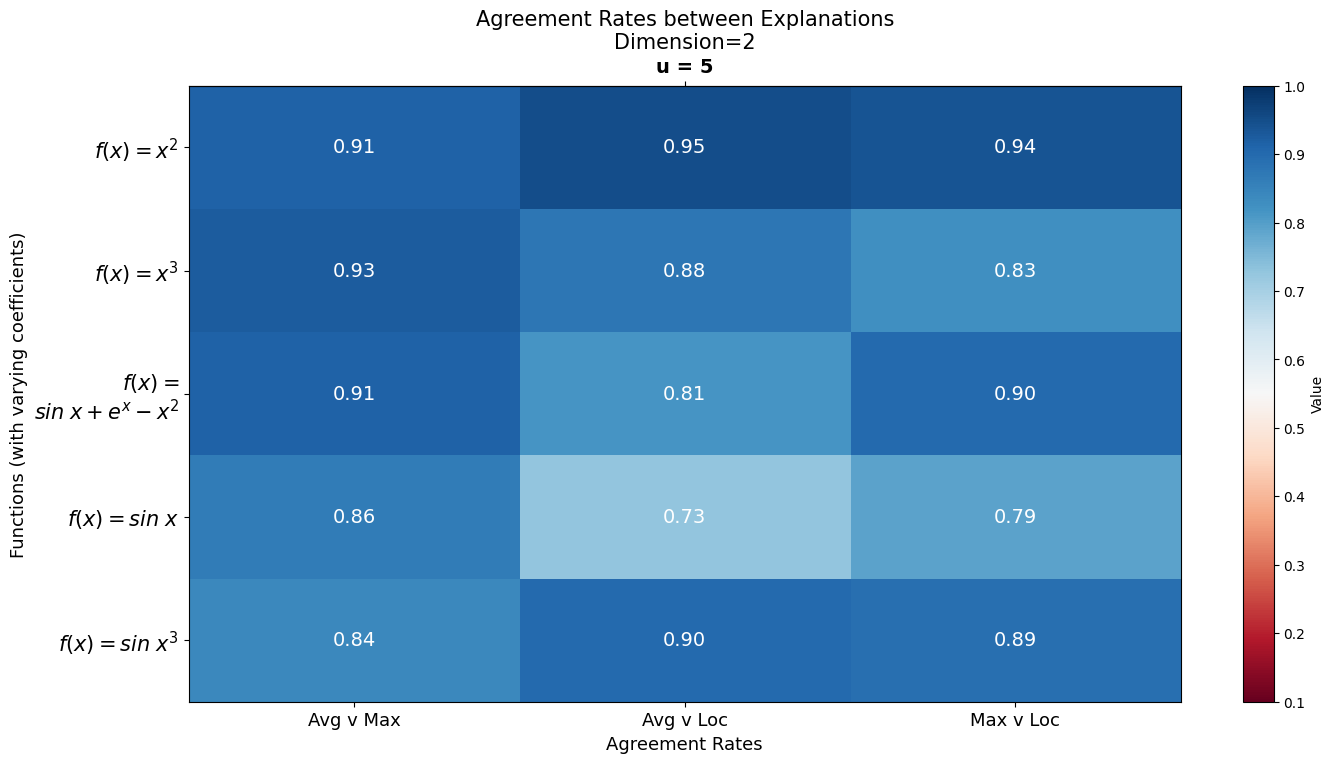

In [ ]:
plot_agreement_rates("2")

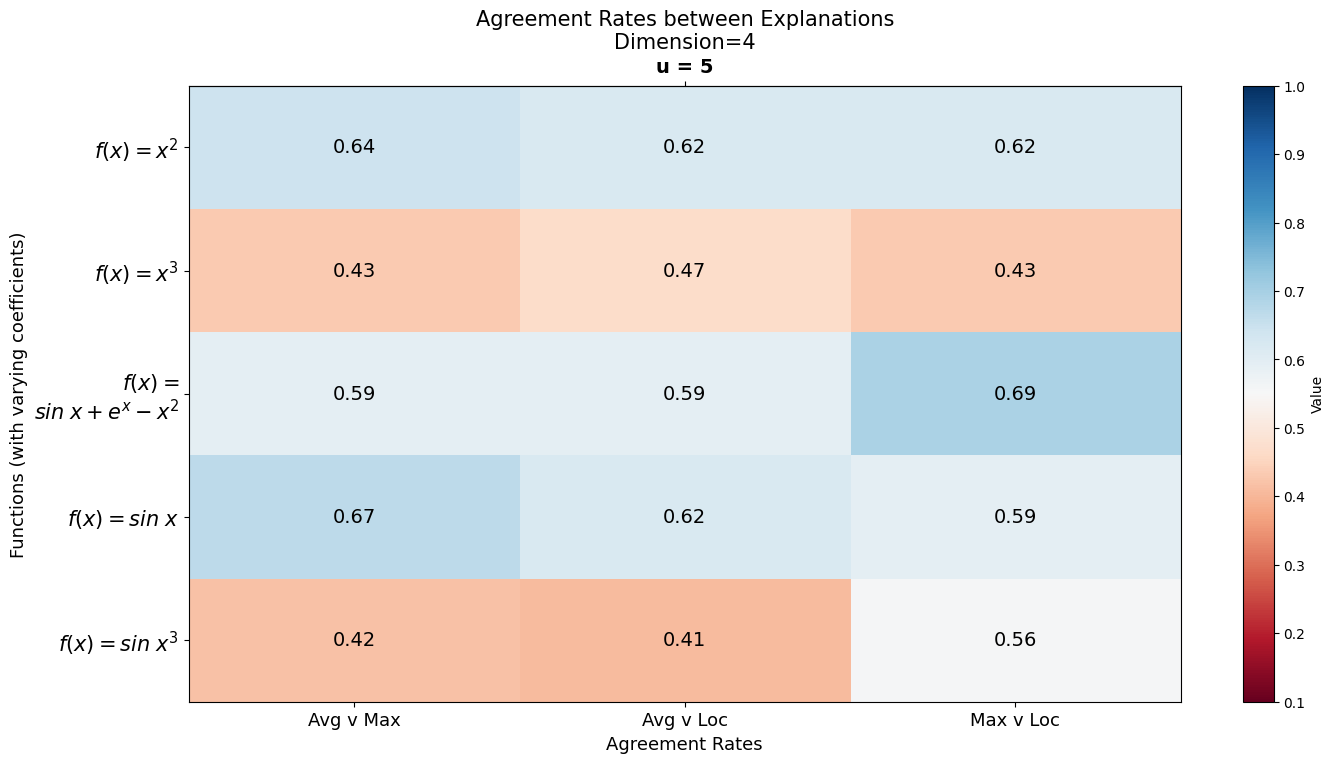

In [ ]:
plot_agreement_rates("4")

**9. Create the 1-dimensional plot of weird behavior occurring when optimizing explanations for $x^3$ under average-sensitivity**
---

In [ ]:
get_explanations("cubed", 1, 1)

Number of Points: 80

DISTANCE BETWEEN FIRST TWO INPUTS 0.12658227848101244
Function: fn_cubed
u: 1
dim: 1
N: 80
metrics: ['max-sens', 'loc-stab', 'avg-sens']
Evaluating explanations for (Function: fn_cubed, dim: 1, r: 1) under robustness loss: max-sens.

Getting optimal explanations for max-sens...
Problem Status: optimal
Problem Status: optimal
Getting optimal explanations for loc-stab...
Problem Status: optimal
Problem Status: optimal
Getting optimal explanations for avg-sens...
Problem Status: optimal


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Problem Status: optimal_inaccurate
Saved: fn=fn_cubed, Dim=1, r=1.
-------------

Evaluating explanations for (Function: fn_cubed, dim: 1, r: 1) under robustness loss: loc-stab.

Getting optimal explanations for max-sens...
Problem Status: optimal
Problem Status: optimal
Getting optimal explanations for loc-stab...
Problem Status: optimal
Problem Status: optimal
Getting optimal explanations for avg-sens...
Problem Status: optimal
Problem Status: optimal_inaccurate
Saved: fn=fn_cubed, Dim=1, r=1.
-------------

Evaluating explanations for (Function: fn_cubed, dim: 1, r: 1) under robustness loss: avg-sens.

Getting optimal explanations for max-sens...
Problem Status: optimal
Problem Status: optimal
Getting optimal explanations for loc-stab...
Problem Status: optimal
Problem Status: optimal
Getting optimal explanations for avg-sens...
Problem Status: optimal
Problem Status: optimal_inaccurate
Saved: fn=fn_cubed, Dim=1, r=1.
-------------



In [ ]:
dim1_json = {}
with open("opt_expls_dim1_u1.json", "r") as f:
    json_dict = json.load(f)
    dim1_json[r] = json_dict

W_E_avg = dim1_json[list(dim1_json.keys())[0]]["fn_cubed"]["avg-sens"]["avg-sens"]["w_opt"]

In [ ]:
X = make_grid(-5, 5, len(W_E_avg), 1)
fn = fn_cubed
W_G = compute_gradient(fn, X)

Text(0.5, 1.0, 'Explanations for $f(x)=x^3$ optimized under Average-Sensitivity\n$D=1$ and $u=1$')

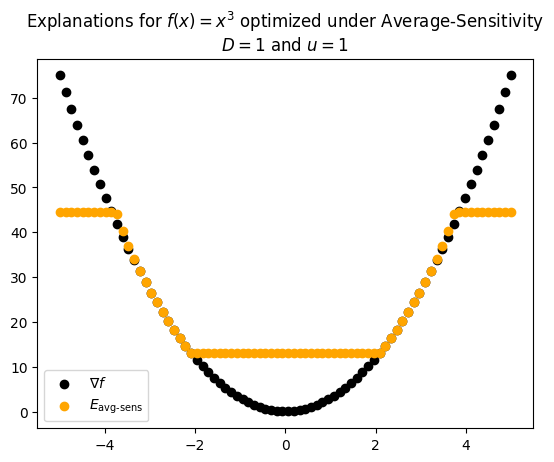

In [ ]:
plt.scatter(X, W_G, color="black", label="$\\nabla f$")
plt.scatter(X, W_E_avg, color="orange", label="$E_{\\text{avg-sens}}$")
plt.legend()
plt.title("Explanations for $f(x)=x^3$ optimized under Average-Sensitivity\n$D=1$ and $u=1$")